## Watermarking in Frequency Domain

### import libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

The following code is just to show plots bigger than defualt in jupyter notebook

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

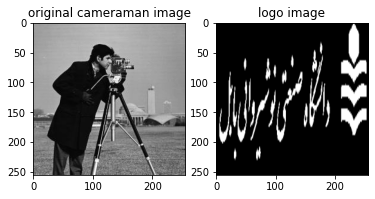

In [3]:
image = cv2.imread('images/camera_256.JPG', cv2.IMREAD_GRAYSCALE)
logo = cv2.imread('images/Logo_NIT_Binary.png', cv2.IMREAD_GRAYSCALE)

logo = cv2.resize(logo, image.shape)

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("original cameraman image")
plt.subplot(1, 2, 2)
plt.imshow(logo, cmap="gray")
plt.title("logo image")
plt.show()

#### fourier transform of images

(256, 256)


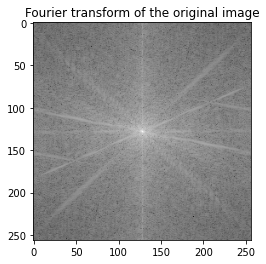

In [28]:
# apply a 2D fast Fourier transform to the grayscale image
f_image = np.fft.fft2(image)
fshift_image = np.fft.fftshift(f_image)

# visualize the Fourier representation of the image
magnitude_spectrum = 20* np.log(np.abs(fshift_image))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier transform of the original image")
plt.show()

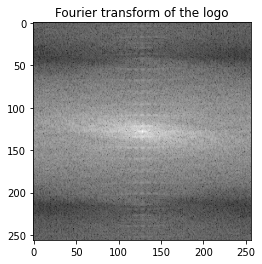

In [5]:
# apply a 2D fast Fourier transform to the grayscale logo
f_logo = np.fft.fft2(logo)
fshift_logo = np.fft.fftshift(f_logo)

# visualize the Fourier representation of the logo
magnitude_spectrum = 20 * np.log(np.abs(fshift_logo))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier transform of the logo")
plt.show()

### Lowpath filter

### create mask

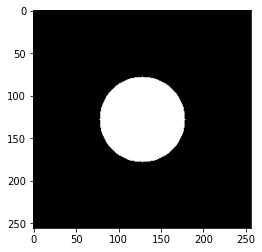

In [6]:
# Create a circular mask for the low pass filter
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Define the radius of the circular low-pass filter
r = 50

mask = np.zeros((rows, cols), np.uint8)
cv2.circle(mask, (ccol, crow), int(r), 1, -1)

plt.imshow(mask, cmap='gray')
plt.show()

#### apply lowpath filter

C:\Users\User\AppData\Local\Temp\ipykernel_6932\2181962711.py:3: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f_image_filtered))


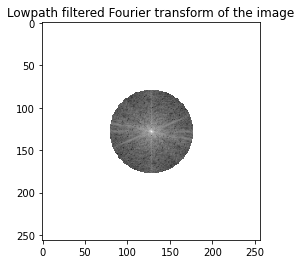

In [25]:
f_image_filtered = fshift_image * mask

magnitude_spectrum = 20 * np.log(np.abs(f_image_filtered))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Lowpath filtered Fourier transform of the image")
plt.show()

#### Inverse Fourier Transform

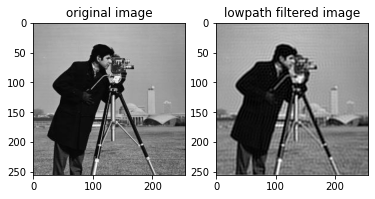

In [8]:
ifshift_image = np.fft.fftshift(f_image_filtered)
lowpath_filtered_image = np.fft.ifft2(ifshift_image).real
lowpath_filtered_image = np.uint8(np.clip(lowpath_filtered_image, 0, 255))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("original image")
plt.subplot(1, 2, 2)
plt.imshow(lowpath_filtered_image, cmap="gray")
plt.title("lowpath filtered image")
plt.show()

(256, 256)


C:\Users\User\AppData\Local\Temp\ipykernel_6932\1081776783.py:3: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f_logo_filtered))


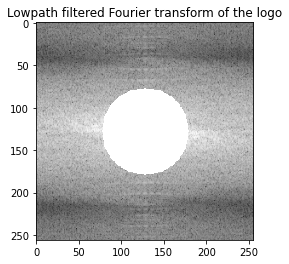

In [30]:
f_logo_filtered = fshift_logo * (1 - mask)

magnitude_spectrum = 20 * np.log(np.abs(f_logo_filtered))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Lowpath filtered Fourier transform of the logo")
plt.show()

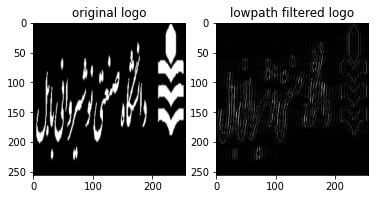

In [10]:
ifshift_logo = np.fft.fftshift(f_logo_filtered)
lowpath_filtered_logo = np.fft.ifft2(ifshift_logo).real
lowpath_filtered_logo = np.uint8(np.clip(lowpath_filtered_logo, 0, 255))

plt.subplot(1, 2, 1)
plt.imshow(logo, cmap="gray")
plt.title("original logo")
plt.subplot(1, 2, 2)
plt.imshow(lowpath_filtered_logo, cmap="gray")
plt.title("lowpath filtered logo")
plt.show()

### Evaluate  
I use two evaluating metrics here: MSE and PSNR

In [11]:
from math import log10, sqrt
def MSE(original, modified):
    mse = np.mean((original - modified) ** 2)
    return mse

def PSNR(original, modified):
    mse = MSE(original, modified)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def evaluate(original, modified):
    mse = MSE(original, modified)
    psnr = PSNR(original, modified)
    return mse, psnr

### Encode the Watermark

I add the watermark to the image, both in frequency domain

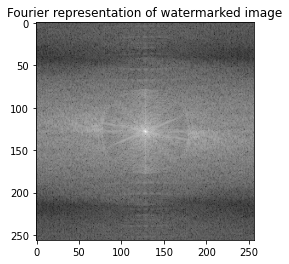

In [12]:
f_watermarked_image = f_image_filtered + f_logo_filtered
magnitude_spectrum = 20 * np.log(np.abs(f_watermarked_image))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier representation of watermarked image")
plt.show()

convert the frequency domain watermarked image to spatial domain image

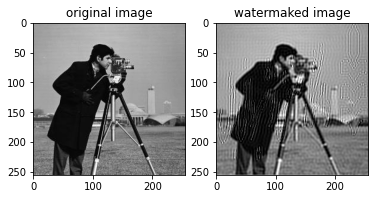

lsb method's MSE: 68.31629943847656, bp method's PSNR: 29.7855602744013


In [13]:
ifshift_watermarked_image = np.fft.fftshift(f_watermarked_image)
watermarked_image = np.fft.ifft2(ifshift_watermarked_image).real
watermarked_image = np.uint8(np.clip(watermarked_image, 0, 255))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("original image")
plt.subplot(1, 2, 2)
plt.imshow(watermarked_image, cmap="gray")
plt.title("watermaked image")
plt.show()

watermarked_image_mse, watermarked_image_psnr = evaluate(image, watermarked_image)
print(f"lsb method's MSE: {watermarked_image_mse}, bp method's PSNR: {watermarked_image_psnr}")

### Decode the Watermark

In [14]:
def decode(watermarked_image, mask):
    # first transform the image to frequency domain
    f_watermarked_image = np.fft.fft2(watermarked_image)
    f_watermarked_image = np.fft.fftshift(f_watermarked_image)

    f_extracted_image = f_watermarked_image * mask
    ifshift_extracted_image = np.fft.fftshift(f_extracted_image)
    extracted_image = np.fft.ifft2(ifshift_extracted_image).real
    extracted_image = np.uint8(np.clip(extracted_image, 0, 255))

    f_extracted_logo = f_watermarked_image * (1-mask)
    ifshift_extracted_logo = np.fft.fftshift(f_extracted_logo)
    extracted_logo = np.fft.ifft2(ifshift_extracted_logo).real
    extracted_logo = np.uint8(np.clip(extracted_logo, 0, 255))

    return extracted_image, extracted_logo

#### extract the camerman image and the logo

In [15]:
extracted_image, extracted_logo = decode(watermarked_image, mask)

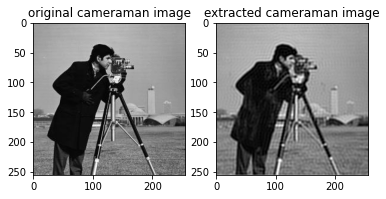

MSE: 45.444061279296875, PSNR: 31.55603224072258


In [16]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("original cameraman image")
plt.subplot(1, 2, 2)
plt.imshow(extracted_image, cmap="gray")
plt.title("extracted cameraman image")
plt.show()
extracted_image_mse, extracted_image_psnr = evaluate(image, extracted_image)
print(f"MSE: {extracted_image_mse}, PSNR: {extracted_image_psnr}")

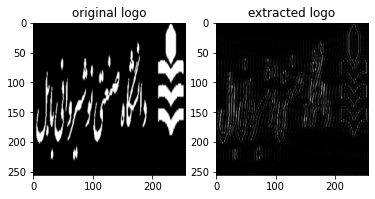

MSE: 26.1383056640625, PSNR: 33.95802928526099


In [17]:
plt.subplot(1, 2, 1)
plt.imshow(logo, cmap="gray")
plt.title("original logo")
plt.subplot(1, 2, 2)
plt.imshow(extracted_logo, cmap="gray")
plt.title("extracted logo")
plt.show()
extracted_logo_mse, extracted_logo_psnr = evaluate(logo, extracted_logo)
print(f"MSE: {extracted_logo_mse}, PSNR: {extracted_logo_psnr}")

## Nosie

### add Gaussian noise

In [18]:
def add_gaussian_noise(image, mean, variance):
    standard_deviation = np.sqrt(variance)
    # Create random normal (Gaussian) distribution
    gaussian_noise = np.random.normal(mean, standard_deviation, image.shape)

    noisey_image = (image + gaussian_noise)

    return noisey_image

Here, according to the previous assignment I should produce 4 noised images for each methods with noise variances 0.15, 0.2, 0.5 and 2.0 and have a mean of 0 for all of them 

In [19]:
noised_watermarked_image_variance02 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.02)
noised_watermarked_image_variance15 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.15)
noised_watermarked_image_variance50 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.5)
noised_watermarked_image_variance200 = add_gaussian_noise(
    watermarked_image, mean=0, variance=2)


#### visualizing noised watermaked images

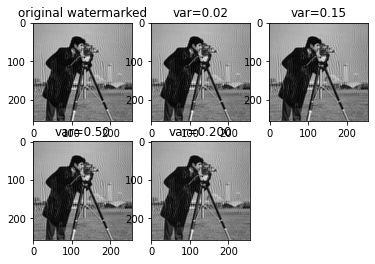

In [20]:
plt.subplot(2, 3, 1)
plt.imshow(watermarked_image, cmap="gray")
plt.title("original watermarked")

plt.subplot(2, 3, 2)
plt.imshow(noised_watermarked_image_variance02, cmap="gray")
plt.title("var=0.02")

plt.subplot(2, 3, 3)
plt.imshow(noised_watermarked_image_variance15, cmap="gray")
plt.title("var=0.15")

plt.subplot(2, 3, 4)
plt.imshow(noised_watermarked_image_variance50, cmap="gray")
plt.title("var=0.50")

plt.subplot(2, 3, 5)
plt.imshow(noised_watermarked_image_variance200, cmap="gray")
plt.title("var=0.200")
plt.show()

### decode cameraman and logo images from noised watermaked images

In [21]:
noised_extracted_image_variance02, noised_extracted_logo_variance02 = decode(noised_watermarked_image_variance02, mask)
noised_extracted_image_variance15, noised_extracted_logo_variance15 = decode(noised_watermarked_image_variance02, mask)
noised_extracted_image_variance50, noised_extracted_logo_variance50 = decode(noised_watermarked_image_variance02, mask)
noised_extracted_image_variance200, noised_extracted_logo_variance200 = decode(noised_watermarked_image_variance02, mask)

#### visualizing extracted cameraman images

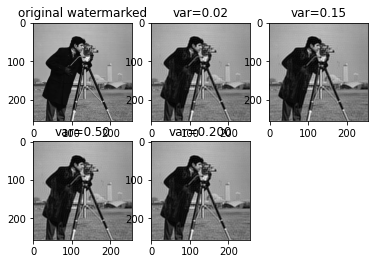

In [22]:
plt.subplot(2, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("original watermarked")

plt.subplot(2, 3, 2)
plt.imshow(noised_extracted_image_variance02, cmap="gray")
plt.title("var=0.02")

plt.subplot(2, 3, 3)
plt.imshow(noised_extracted_image_variance15, cmap="gray")
plt.title("var=0.15")

plt.subplot(2, 3, 4)
plt.imshow(noised_extracted_image_variance50, cmap="gray")
plt.title("var=0.50")

plt.subplot(2, 3, 5)
plt.imshow(noised_extracted_image_variance200, cmap="gray")
plt.title("var=0.200")
plt.show()

#### visualizing extracted cameraman images

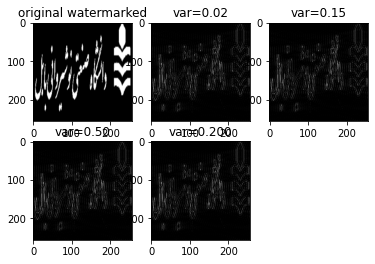

In [23]:
plt.subplot(2, 3, 1)
plt.imshow(logo, cmap="gray")
plt.title("original watermarked")

plt.subplot(2, 3, 2)
plt.imshow(noised_extracted_logo_variance02, cmap="gray")
plt.title("var=0.02")

plt.subplot(2, 3, 3)
plt.imshow(noised_extracted_logo_variance15, cmap="gray")
plt.title("var=0.15")

plt.subplot(2, 3, 4)
plt.imshow(noised_extracted_logo_variance50, cmap="gray")
plt.title("var=0.50")

plt.subplot(2, 3, 5)
plt.imshow(noised_extracted_logo_variance200, cmap="gray")
plt.title("var=0.200")
plt.show()

